<a href="https://colab.research.google.com/github/GHM-ML/Natural-Language-Processing/blob/main/Twitter_Sentiment_Analysis_(Disaster).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import re
import json
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM, SpatialDropout1D
from keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username": USERNAME,"key":KEY}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
    
!mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-getting-started

In [ ]:
!unzip nlp-getting-started

In [9]:
train = pd.read_csv('/content/train.csv')

In [10]:
test = pd.read_csv('/content/test.csv')

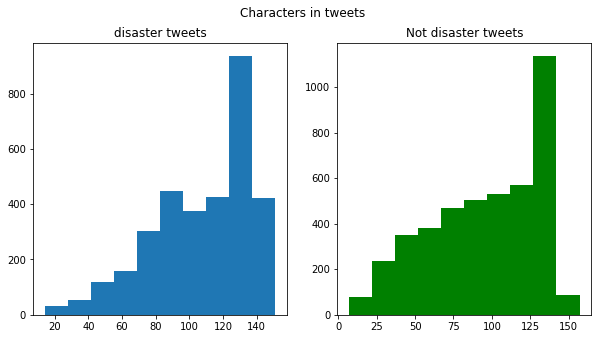

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len)
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len, color = 'green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

In [12]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 18 artists>

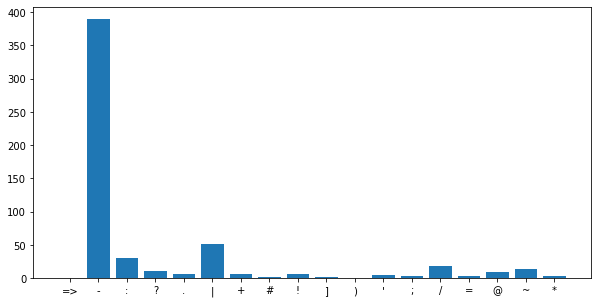

In [13]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)
from collections import defaultdict
dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

In [14]:
x_train = train.drop('target', axis = 1)
y_train = train['target']
x_test = test

In [15]:
x_train

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...


In [16]:
x_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [17]:
def clean_text(tweet):
    tweet = tweet.lower() #text to lowercase
    tweet = re.sub(r'\$\w*', '', tweet) #remove stock market symbols
    tweet = re.sub(r'^RT[\s]+', '', tweet) #remove RT or Retweet symbols
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) #remove links
    tweet = re.sub(r'#', '', tweet) #remove # or Hashtag symbols
    tweet = re.sub(r'\[.*?\]', '', tweet) #remove things inside brackets
    tweet = re.sub(r'\w*\d\w*', '', tweet) #words that contain numbers
    return tweet

def clean_punctuation(tweet):
    tweet = "".join(word for word in tweet if word not in set(string.punctuation))
    return tweet

def clean_stopwords(tweet):
    STOPWORDS = stopwords.words("english")
    tweet = " ".join(word for word in tweet.split() if word not in STOPWORDS)
    return tweet

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_tweet(tweet):
    tweet = clean_text(tweet)
    tweet = clean_punctuation(tweet)
    tweet = clean_stopwords(tweet)
    tweet = remove_emoji(tweet)
    return tweet

def manual_label_target(df):
    df.loc[df["text"]==
           "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect",
           "target"]= 0
    df.loc[df["text"]==
          "#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption",
          "target"] = 0
    df.loc[df["text"]==
          ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4",
          "target"] = 0
    df.loc[df["text"]==
          "CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring",
          "target"] = 1
    df.loc[df["text"]==
          "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam",
          "target"] = 0
    df.loc[df["text"]==
          "Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife",
          "target"] = 0
    df.loc[df["text"]==
          "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
          "target"] = 0
    df.loc[df["text"]=="To fight bioterrorism sir.", "target"] = 0
    df.loc[df["text"]==
          "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time",
          "target"] = 0
    return df

In [18]:
x_train = manual_label_target(x_train)

x_train['clean_tweet'] = x_train.text.apply(clean_tweet)
x_test['clean_tweet'] = x_test.text.apply(clean_tweet)

In [19]:
x_test

,id,keyword,location,text,clean_tweet
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri worse last hurricane cityamp hardest ...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo


In [20]:
x_train.sample(20)

,id,keyword,location,text,target,clean_tweet
5868,8385,ruin,#RedSoxNation,@JulieChen she shouldn't. Being with them is g...,NaN,juliechen shouldnt gonna ruin game vanessa gre...
5402,7711,panicking,PARACHUTE,idm if you burn the whole gotham city bcs I'm ...,NaN,idm burn whole gotham city bcs im gonna laugh ...
7592,10847,NaN,NaN,An IS group suicide bomber detonated an explos...,NaN,group suicide bomber detonated explosivespacke...
6926,9934,trouble,Displaced Son of TEXAS!,ÛÏ@YMcglaun: @JulieKragt @WildWestSixGun You'...,NaN,ûïymcglaun juliekragt wildwestsixgun youre lo...
1421,2050,casualties,"Inglewood, CA",Stay tuned or don't idc #casualties http://t.c...,NaN,stay tuned dont idc casualties
5212,7444,obliterated,NaN,I think I'll get obliterated tonight,NaN,think ill get obliterated tonight
1960,2822,cyclone,"Washington, DC",'The cyclone derives its powers from a calm ce...,NaN,cyclone derives powers calm center person norm...
794,1152,blight,"Colombo,Sri Lanka.",Releases on the planing level -\n\n1. Constell...,NaN,releases planing level constellation blight ga...
6924,9932,trouble,"Rochester Hills, MI",Live updates: Boyd gets out of trouble in 5th ...,NaN,live updates boyd gets trouble
2930,4211,drowned,WorldWideWeb,#DW Hundreds feared drowned as migrant boat ca...,NaN,dw hundreds feared drowned migrant boat capsiz...


In [21]:
x_train.drop(['id','keyword','location','text', 'target'],axis=1,inplace=True)
x_test.drop(['id','keyword','location','text'],axis=1,inplace=True)

In [22]:
x_train

,clean_tweet
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked shelter place notified officer...
3,people receive wildfires evacuation orders cal...
4,got sent photo ruby alaska smoke wildfires pou...
...,...
7608,two giant cranes holding bridge collapse nearb...
7609,ariaahrary thetawniest control wild fires cali...
7610,volcano hawaii
7611,police investigating ebike collided car little...


In [23]:
x_test

,clean_tweet
0,happened terrible car crash
1,heard earthquake different cities stay safe ev...
2,forest fire spot pond geese fleeing across str...
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills china taiwan
...,...
3258,earthquake safety los angeles ûò safety faste...
3259,storm ri worse last hurricane cityamp hardest ...
3260,green line derailment chicago
3261,meg issues hazardous weather outlook hwo


In [26]:
lemmatizer = WordNetLemmatizer()

x_train['clean_tweet'] = x_train['clean_tweet'].apply(lambda x: lemmatizer.lemmatize(x))
x_test['clean_tweet'] = x_test['clean_tweet'].apply(lambda x: lemmatizer.lemmatize(x))

In [27]:
training_message = x_train['clean_tweet'].tolist()
testing_message = x_test['clean_tweet'].tolist()

In [28]:
corpus = []
for text in x_train['clean_tweet']:
    words = [word.lower() for word in word_tokenize(text)] 
    corpus.append(words)
num_words = len(corpus)
print(num_words)

7613


In [29]:
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(training_message)
training_message = tokenizer.texts_to_sequences(training_message)
testing_message = tokenizer.texts_to_sequences(testing_message)

In [30]:
training_padded = pad_sequences(training_message,maxlen=35, truncating='post', padding='post')
testing_padded = pad_sequences(testing_message,maxlen=35, truncating='post', padding='post')

In [31]:
training_padded = np.array(training_padded)
testing_padded = np.array(testing_padded)
training_labels = np.array(y_train)

In [32]:
embedding = {}
with open("/content/glove.twitter.27B.100d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding[word] = vectors
        
file.close()

embedding_matrix = np.zeros((num_words+1, 100))
for i, word in tokenizer.index_word.items():
    if i < (num_words+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [35]:
model = Sequential([
                    Embedding(num_words + 1,embeddings_initializer=Constant(embedding_matrix),output_dim = 100,input_length=35),
                    LSTM(100, recurrent_dropout = .2),
                    Dense(1, activation = 'sigmoid')
                    ])

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           761400    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 841,901
Trainable params: 841,901
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(training_padded, training_labels,
epochs=20,
batch_size=32,
validation_split=0.3)

Epoch 1/20
167/167 [==============================] - 27s 125ms/step - loss: 0.6921 - acc: 0.5782 - val_loss: 0.6912 - val_acc: 0.5582
Epoch 2/20
167/167 [==============================] - 22s 133ms/step - loss: 0.6889 - acc: 0.5755 - val_loss: 0.6863 - val_acc: 0.5582
Epoch 3/20
167/167 [==============================] - 21s 123ms/step - loss: 0.6741 - acc: 0.5872 - val_loss: 0.6459 - val_acc: 0.6506
Epoch 4/20
167/167 [==============================] - 27s 160ms/step - loss: 0.5860 - acc: 0.7335 - val_loss: 0.5150 - val_acc: 0.7925
Epoch 5/20
167/167 [==============================] - 21s 125ms/step - loss: 0.5194 - acc: 0.7675 - val_loss: 0.4820 - val_acc: 0.7881
Epoch 6/20
167/167 [==============================] - 21s 123ms/step - loss: 0.5018 - acc: 0.7750 - val_loss: 0.4707 - val_acc: 0.7912
Epoch 7/20
167/167 [==============================] - 21s 124ms/step - loss: 0.4919 - acc: 0.7819 - val_loss: 0.4624 - val_acc: 0.7947
Epoch 8/20
167/167 [==============================] - 2

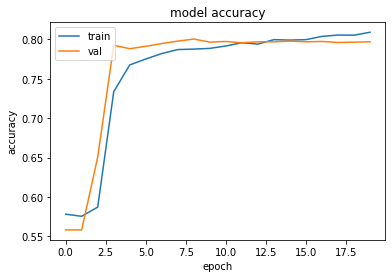

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

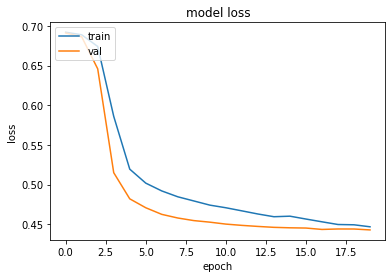

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()